In [3]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Convolution1D, MaxPooling1D, Flatten,  Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

np.random.seed(7)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore") 

df = pd.read_hdf('../data/DeepLearning.h5', 'Data_Gold')


In [4]:
for c in df.columns:
    df[c+'_ret'] = df[c].pct_change().fillna(0)

df

,Gold,DJI,InterestRate,Inflation,Reserves,Gold_ret,DJI_ret,InterestRate_ret,Inflation_ret,Reserves_ret
DATE,,,,,,,,,,
1985-02-01,304.80,1277.719971,8.50,106.300,37.251,0.000000,0.000000,0.000000,0.000000,0.000000
1985-03-01,288.10,1299.359985,8.58,106.800,37.889,-0.054790,0.016936,0.009412,0.004704,0.017127
1985-04-01,324.65,1272.750000,8.27,107.000,37.661,0.126866,-0.020479,-0.036131,0.001873,-0.006018
1985-05-01,315.60,1242.050049,7.97,107.200,38.289,-0.027876,-0.024121,-0.036276,0.001869,0.016675
1985-06-01,313.15,1315.410034,7.53,107.500,39.386,-0.007763,0.059064,-0.055207,0.002799,0.028651
...,...,...,...,...,...,...,...,...,...,...
2016-10-01,1327.90,18308.150391,0.40,241.694,2218.542,0.017002,-0.006034,0.000000,0.002855,-0.059547
2016-11-01,1284.40,18037.099609,0.41,242.199,2233.412,-0.032758,-0.014805,0.025000,0.002089,0.006703
2016-12-01,1168.75,19191.929688,0.54,242.821,2052.015,-0.090042,0.064025,0.317073,0.002568,-0.081220


In [5]:
def create_dataset(dataset, look_back=1, columns = ['Gold']):
    dataX, dataY = [], []
    for i in range(len(dataset.index)):
        if i <= look_back:
            continue
        a = None
        for c in columns:
            b = dataset.loc[dataset.index[i-look_back:i], c].as_matrix()
            if a is None:
                a = b
            else:
                a = np.append(a,b)
        dataX.append(a)
        dataY.append(dataset.loc[dataset.index[i], columns].as_matrix())
    return np.array(dataX), np.array(dataY)


In [6]:
look_back = 12
sc = StandardScaler()
df.loc[:, 'Gold'] = sc.fit_transform(np.array(df.loc[:, 'Gold']).reshape(-1,1))
sc1 = StandardScaler()
df.loc[:, 'Inflation'] = sc1.fit_transform(np.array(df.loc[:, 'Inflation']).reshape(-1,1))
sc2 = StandardScaler()
df.loc[:, 'InterestRate'] = sc1.fit_transform(np.array(df.loc[:, 'InterestRate']).reshape(-1,1))
sc2 = StandardScaler()
df.loc[:, 'DJI'] = sc1.fit_transform(np.array(df.loc[:, 'DJI']).reshape(-1,1))

df.head()

,Gold,DJI,InterestRate,Inflation,Reserves,Gold_ret,DJI_ret,InterestRate_ret,Inflation_ret,Reserves_ret
DATE,,,,,,,,,,
1985-02-01,-0.769515,-1.469820,1.680957,-1.698929,37.251,0.000000,0.000000,0.000000,0.000000,0.000000
1985-03-01,-0.808540,-1.465421,1.709193,-1.686811,37.889,-0.054790,0.016936,0.009412,0.004704,0.017127
1985-04-01,-0.723128,-1.470830,1.599781,-1.681964,37.661,0.126866,-0.020479,-0.036131,0.001873,-0.006018
1985-05-01,-0.744276,-1.477070,1.493899,-1.677116,38.289,-0.027876,-0.024121,-0.036276,0.001869,0.016675
1985-06-01,-0.750002,-1.462159,1.338605,-1.669845,39.386,-0.007763,0.059064,-0.055207,0.002799,0.028651


In [7]:
train_df = df.loc[df.index < pd.to_datetime('2016-01-01')]

timeseries = np.asarray(df.Gold)
timeseries = np.atleast_2d(timeseries)
if timeseries.shape[0] == 1:
        timeseries = timeseries.T
X = np.atleast_3d(np.array([timeseries[start:start + look_back] for start in range(0, timeseries.shape[0] - look_back)]))
y = timeseries[look_back:]

predictors = ['Gold']#, 'DJI','Inflation']#, 'InterestRate']
#TRAIN_SIZE = train_x.shape[0]
#EMB_SIZE = look_back
model = Sequential()
model.add(LSTM(input_shape = (1,), input_dim=1, output_dim=6, return_sequences=True))
model.add(LSTM(input_shape = (1,), input_dim=1, output_dim=6, return_sequences=False))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss="mse", optimizer="rmsprop")
model.fit(X, 
          y, 
          epochs=1000, 
          batch_size=80, verbose=1, shuffle=False)


Epoch 1/1000
373/373 [==============================] - 1s 3ms/step - loss: 0.8823
Epoch 2/1000
373/373 [==============================] - 0s 267us/step - loss: 0.7787
Epoch 3/1000
373/373 [==============================] - 0s 282us/step - loss: 0.7135
Epoch 4/1000
373/373 [==============================] - 0s 269us/step - loss: 0.6550
Epoch 5/1000
373/373 [==============================] - 0s 277us/step - loss: 0.6002
Epoch 6/1000
373/373 [==============================] - 0s 257us/step - loss: 0.5480
Epoch 7/1000
373/373 [==============================] - 0s 253us/step - loss: 0.4979
Epoch 8/1000
373/373 [==============================] - 0s 257us/step - loss: 0.4499
Epoch 9/1000
373/373 [==============================] - 0s 255us/step - loss: 0.4044
Epoch 10/1000
373/373 [==============================] - 0s 270us/step - loss: 0.3614
Epoch 11/1000
373/373 [==============================] - 0s 268us/step - loss: 0.3212
Epoch 12/1000
373/373 [==============================] - 0s 270u

373/373 [==============================] - 0s 258us/step - loss: 0.0358
Epoch 94/1000
373/373 [==============================] - 0s 269us/step - loss: 0.0357
Epoch 95/1000
373/373 [==============================] - 0s 258us/step - loss: 0.0355
Epoch 96/1000
373/373 [==============================] - 0s 257us/step - loss: 0.0353
Epoch 97/1000
373/373 [==============================] - 0s 248us/step - loss: 0.0352
Epoch 98/1000
373/373 [==============================] - 0s 274us/step - loss: 0.0350
Epoch 99/1000
373/373 [==============================] - 0s 199us/step - loss: 0.0349
Epoch 100/1000
373/373 [==============================] - 0s 277us/step - loss: 0.0347
Epoch 101/1000
373/373 [==============================] - 0s 278us/step - loss: 0.0346
Epoch 102/1000
373/373 [==============================] - 0s 279us/step - loss: 0.0344
Epoch 103/1000
373/373 [==============================] - 0s 269us/step - loss: 0.0343
Epoch 104/1000
373/373 [==============================] - 0s 266

373/373 [==============================] - 0s 205us/step - loss: 0.0263
Epoch 188/1000
373/373 [==============================] - 0s 204us/step - loss: 0.0262
Epoch 189/1000
373/373 [==============================] - 0s 250us/step - loss: 0.0261
Epoch 190/1000
373/373 [==============================] - 0s 234us/step - loss: 0.0261
Epoch 191/1000
373/373 [==============================] - 0s 254us/step - loss: 0.0260
Epoch 192/1000
373/373 [==============================] - 0s 295us/step - loss: 0.0259
Epoch 193/1000
373/373 [==============================] - 0s 267us/step - loss: 0.0259
Epoch 194/1000
373/373 [==============================] - 0s 262us/step - loss: 0.0258
Epoch 195/1000
373/373 [==============================] - 0s 275us/step - loss: 0.0257
Epoch 196/1000
373/373 [==============================] - 0s 241us/step - loss: 0.0257
Epoch 197/1000
373/373 [==============================] - 0s 203us/step - loss: 0.0256
Epoch 198/1000
373/373 [==============================] - 

373/373 [==============================] - 0s 267us/step - loss: 0.0208
Epoch 282/1000
373/373 [==============================] - 0s 264us/step - loss: 0.0207
Epoch 283/1000
373/373 [==============================] - 0s 289us/step - loss: 0.0207
Epoch 284/1000
373/373 [==============================] - 0s 277us/step - loss: 0.0206
Epoch 285/1000
373/373 [==============================] - 0s 268us/step - loss: 0.0206
Epoch 286/1000
373/373 [==============================] - 0s 291us/step - loss: 0.0205
Epoch 287/1000
373/373 [==============================] - 0s 245us/step - loss: 0.0205
Epoch 288/1000
373/373 [==============================] - 0s 205us/step - loss: 0.0204
Epoch 289/1000
373/373 [==============================] - 0s 182us/step - loss: 0.0204
Epoch 290/1000
373/373 [==============================] - 0s 195us/step - loss: 0.0203
Epoch 291/1000
373/373 [==============================] - 0s 235us/step - loss: 0.0203
Epoch 292/1000
373/373 [==============================] - 

373/373 [==============================] - 0s 252us/step - loss: 0.0167
Epoch 376/1000
373/373 [==============================] - 0s 257us/step - loss: 0.0167
Epoch 377/1000
373/373 [==============================] - 0s 203us/step - loss: 0.0166
Epoch 378/1000
373/373 [==============================] - 0s 205us/step - loss: 0.0166
Epoch 379/1000
373/373 [==============================] - 0s 239us/step - loss: 0.0166
Epoch 380/1000
373/373 [==============================] - 0s 291us/step - loss: 0.0165
Epoch 381/1000
373/373 [==============================] - 0s 301us/step - loss: 0.0165
Epoch 382/1000
373/373 [==============================] - 0s 207us/step - loss: 0.0165
Epoch 383/1000
373/373 [==============================] - 0s 276us/step - loss: 0.0164
Epoch 384/1000
373/373 [==============================] - 0s 227us/step - loss: 0.0164
Epoch 385/1000
373/373 [==============================] - 0s 251us/step - loss: 0.0163
Epoch 386/1000
373/373 [==============================] - 

373/373 [==============================] - 0s 232us/step - loss: 0.0137
Epoch 470/1000
373/373 [==============================] - 0s 241us/step - loss: 0.0137
Epoch 471/1000
373/373 [==============================] - 0s 274us/step - loss: 0.0137
Epoch 472/1000
373/373 [==============================] - 0s 252us/step - loss: 0.0137
Epoch 473/1000
373/373 [==============================] - 0s 230us/step - loss: 0.0136
Epoch 474/1000
373/373 [==============================] - 0s 219us/step - loss: 0.0136
Epoch 475/1000
373/373 [==============================] - 0s 216us/step - loss: 0.0136
Epoch 476/1000
373/373 [==============================] - 0s 220us/step - loss: 0.0136
Epoch 477/1000
373/373 [==============================] - 0s 198us/step - loss: 0.0135
Epoch 478/1000
373/373 [==============================] - 0s 202us/step - loss: 0.0135
Epoch 479/1000
373/373 [==============================] - 0s 193us/step - loss: 0.0135
Epoch 480/1000
373/373 [==============================] - 

373/373 [==============================] - 0s 249us/step - loss: 0.0118
Epoch 564/1000
373/373 [==============================] - 0s 269us/step - loss: 0.0117
Epoch 565/1000
373/373 [==============================] - 0s 209us/step - loss: 0.0117
Epoch 566/1000
373/373 [==============================] - 0s 264us/step - loss: 0.0117
Epoch 567/1000
373/373 [==============================] - 0s 272us/step - loss: 0.0117
Epoch 568/1000
373/373 [==============================] - 0s 250us/step - loss: 0.0117
Epoch 569/1000
373/373 [==============================] - 0s 261us/step - loss: 0.0117
Epoch 570/1000
373/373 [==============================] - 0s 233us/step - loss: 0.0116
Epoch 571/1000
373/373 [==============================] - 0s 271us/step - loss: 0.0116
Epoch 572/1000
373/373 [==============================] - 0s 232us/step - loss: 0.0116
Epoch 573/1000
373/373 [==============================] - 0s 246us/step - loss: 0.0116
Epoch 574/1000
373/373 [==============================] - 

373/373 [==============================] - 0s 273us/step - loss: 0.0104
Epoch 658/1000
373/373 [==============================] - 0s 256us/step - loss: 0.0103
Epoch 659/1000
373/373 [==============================] - 0s 266us/step - loss: 0.0103
Epoch 660/1000
373/373 [==============================] - 0s 290us/step - loss: 0.0103
Epoch 661/1000
373/373 [==============================] - 0s 254us/step - loss: 0.0103
Epoch 662/1000
373/373 [==============================] - 0s 201us/step - loss: 0.0103
Epoch 663/1000
373/373 [==============================] - 0s 256us/step - loss: 0.0103
Epoch 664/1000
373/373 [==============================] - 0s 215us/step - loss: 0.0103
Epoch 665/1000
373/373 [==============================] - 0s 214us/step - loss: 0.0103
Epoch 666/1000
373/373 [==============================] - 0s 222us/step - loss: 0.0102
Epoch 667/1000
373/373 [==============================] - 0s 210us/step - loss: 0.0102
Epoch 668/1000
373/373 [==============================] - 

373/373 [==============================] - 0s 255us/step - loss: 0.0096
Epoch 752/1000
373/373 [==============================] - 0s 254us/step - loss: 0.0094
Epoch 753/1000
373/373 [==============================] - 0s 265us/step - loss: 0.0096
Epoch 754/1000
373/373 [==============================] - 0s 214us/step - loss: 0.0094
Epoch 755/1000
373/373 [==============================] - 0s 244us/step - loss: 0.0095
Epoch 756/1000
373/373 [==============================] - 0s 274us/step - loss: 0.0094
Epoch 757/1000
373/373 [==============================] - 0s 268us/step - loss: 0.0095
Epoch 758/1000
373/373 [==============================] - 0s 265us/step - loss: 0.0094
Epoch 759/1000
373/373 [==============================] - 0s 257us/step - loss: 0.0095
Epoch 760/1000
373/373 [==============================] - 0s 236us/step - loss: 0.0094
Epoch 761/1000
373/373 [==============================] - 0s 219us/step - loss: 0.0095
Epoch 762/1000
373/373 [==============================] - 

373/373 [==============================] - 0s 220us/step - loss: 0.0092
Epoch 846/1000
373/373 [==============================] - 0s 250us/step - loss: 0.0091
Epoch 847/1000
373/373 [==============================] - 0s 255us/step - loss: 0.0092
Epoch 848/1000
373/373 [==============================] - 0s 239us/step - loss: 0.0091
Epoch 849/1000
373/373 [==============================] - 0s 245us/step - loss: 0.0092
Epoch 850/1000
373/373 [==============================] - 0s 274us/step - loss: 0.0091
Epoch 851/1000
373/373 [==============================] - 0s 196us/step - loss: 0.0092
Epoch 852/1000
373/373 [==============================] - 0s 269us/step - loss: 0.0091
Epoch 853/1000
373/373 [==============================] - 0s 279us/step - loss: 0.0092
Epoch 854/1000
373/373 [==============================] - 0s 248us/step - loss: 0.0091
Epoch 855/1000
373/373 [==============================] - 0s 271us/step - loss: 0.0092
Epoch 856/1000
373/373 [==============================] - 

373/373 [==============================] - 0s 243us/step - loss: 0.0091
Epoch 940/1000
373/373 [==============================] - 0s 239us/step - loss: 0.0089
Epoch 941/1000
373/373 [==============================] - 0s 277us/step - loss: 0.0091
Epoch 942/1000
373/373 [==============================] - 0s 294us/step - loss: 0.0089
Epoch 943/1000
373/373 [==============================] - 0s 286us/step - loss: 0.0091
Epoch 944/1000
373/373 [==============================] - 0s 238us/step - loss: 0.0089
Epoch 945/1000
373/373 [==============================] - 0s 245us/step - loss: 0.0091
Epoch 946/1000
373/373 [==============================] - 0s 276us/step - loss: 0.0089
Epoch 947/1000
373/373 [==============================] - 0s 234us/step - loss: 0.0091
Epoch 948/1000
373/373 [==============================] - 0s 239us/step - loss: 0.0089
Epoch 949/1000
373/373 [==============================] - 0s 258us/step - loss: 0.0090
Epoch 950/1000
373/373 [==============================] - 

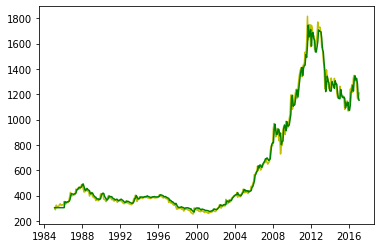

In [8]:
df['Pred'] = df.loc[df.index[0], 'Gold']
for i in range(len(df.index)):
    if i <= look_back:
        continue
    a = None
    for c in predictors:
        b = df.loc[df.index[i-look_back:i], c].as_matrix()
        if a is None:
            a = b
        else:
            a = np.append(a,b)
        a = a
    y = model.predict(a.reshape(1,look_back*len(predictors),1))
    df.loc[df.index[i], 'Pred']=y[0][0]
df.to_hdf('DeepLearning.h5', 'Pred_LSTM')
df.loc[:, 'Gold'] = sc.inverse_transform(df.loc[:, 'Gold'])
df.loc[:, 'Pred'] = sc.inverse_transform(df.loc[:, 'Pred'])
plt.plot(df.Gold,'y')
plt.plot(df.Pred, 'g')